In [1]:
import datetime as dt
import time
import logging
import matplotlib.pyplot as plt
from optibook.synchronous_client import Exchange

import pandas as pd
import numpy as np
from IPython.display import display

from math import floor, ceil
from black_scholes import call_value, put_value, call_delta, put_delta, call_vega, put_vega
from libs import calculate_current_time_to_date, calculate_time_to_date
from IPython.display import clear_output

# Connect to exchange

In [2]:
e = Exchange()
a = e.connect()

logging.getLogger('client').setLevel('ERROR')

2022-04-06 18:51:33,959 [asyncio   ] [MainThread  ] Using selector: EpollSelector
2022-04-06 18:51:33,964 [client    ] [Thread-4    ] background thread started
2022-04-06 18:51:33,995 [client    ] [Thread-4    ] opened connection
2022-04-06 18:51:33,996 [client    ] [Thread-4    ] start read <StreamReader t=<_SelectorSocketTransport fd=91 read=polling write=<idle, bufsize=0>>>
2022-04-06 18:51:34,031 [client    ] [Thread-4    ] logged in!


# Methods

In [3]:
def deleteOrders(instrument_id):
    outstanding = e.get_outstanding_orders(instrument_id)
    for o in outstanding.values():
        result = e.delete_order(instrument_id, order_id=o.order_id)
                        
def sellItAll():
    for s, p in e.get_positions().items():
        if p > 0:
            e.insert_order(s, price=1, volume=p, side='ask', order_type='ioc')
        elif p < 0:
            e.insert_order(s, price=100000, volume=-p, side='bid', order_type='ioc')  
                     
def kill():
    df['id'].apply(deleteOrders)
    sellItAll()
    
def get_mean_price(instrument_id):
    orderbook = e.get_last_price_book(instrument_id)
    if orderbook.bids and orderbook.asks:
        return (orderbook.bids[0].price + orderbook.asks[0].price) / 2
    
def get_bids(instrument_id):
    if e.get_last_price_book(instrument_id).bids:
        return e.get_last_price_book(instrument_id).bids[0].price
    else:
        return 1

def get_asks(instrument_id):
    if e.get_last_price_book(instrument_id).asks:
        return e.get_last_price_book(instrument_id).asks[0].price
    else:
        return 10000
    
def get_position(instrument_id):
    return e.get_positions()[instrument_id]

def buy_instrument(instrument_id, desired_bid, max_volume):
    result = e.insert_order(instrument_id, price=desired_bid, volume=max_volume, side='bid', order_type='limit')
    
def sell_instrument(instrument_id, desired_ask, max_volume):
    result = e.insert_order(instrument_id, price=desired_ask, volume=max_volume, side='ask', order_type='limit')
    
def even_number_background(cell_value):

    red = 'background-color: red;'
    green = 'background-color: lightgreen;'
    default = ''

    if type(cell_value) in [bool]:
        if cell_value == False:
            return red
        if cell_value == True:
            return green
        
    return default

In [4]:
def executeHedge(delta, id_position, instrument_id):
    """
    Method for executing the hedge.
    """
    
    if delta + id_position != 0:
                        
        if delta <= 0 and id_position > 0:
            if abs(id_position) > abs(delta):
                volume = abs(id_position) - abs(delta)
                id_position = id_position - volume
                result = e.insert_order(instrument_id, price=1, volume=volume, side='ask', order_type='ioc')
            elif abs(id_position) < abs(delta):
                volume = abs(delta) - abs(id_position)
                id_position = id_position + volume
                result = e.insert_order(instrument_id, price=10000, volume=volume, side='bid', order_type='ioc')
                
        elif delta >= 0 and id_position <= 0:
            if abs(id_position) < abs(delta):
                volume = abs(abs(delta) - abs(id_position))
                id_position = id_position - volume
                result = e.insert_order(instrument_id, price=1, volume=volume, side='ask', order_type='ioc')
            elif abs(id_position) > abs(delta):
                volume = abs(abs(delta) - abs(id_position))
                id_position = id_position + volume
                result = e.insert_order(instrument_id, price=10000, volume=volume, side='bid', order_type='ioc')
            
        elif delta <= 0 and id_position <= 0:
            volume = abs(id_position) + abs(delta)
            id_position = id_position + volume
            result = e.insert_order(instrument_id, price=10000, volume=volume, side='bid', order_type='ioc')
        elif delta > 0 and id_position > 0:
            volume = abs(id_position) + abs(delta)
            id_position = id_position - volume
            result = e.insert_order(instrument_id, price=1, volume=volume, side='ask', order_type='ioc')
                    
        assert volume > 0
        assert abs(delta) == abs(id_position)
        assert delta != id_position or delta == 0

In [5]:
def update_positions_and_delta():
    
    # Add position to dataframe
    df['Position'] = df['id'].apply(get_position)

    # Calculate outstanding delta
    df['Put delta'] = put_delta(df['S'], df['strike'], df['T'], 0, df['Sigma'])

    df.loc[df['callput'] == 'put', 'Delta'] = round(df['Put delta'] * df['Position'], 2)
    df.loc[df['callput'] == 'call', 'Delta'] = round((1 + df['Put delta']) * df['Position'], 2)

In [10]:
def reduce_position(df, reduction):
    """
    Input:
    ---------
     df : pd.DataFrame()
         Our trading book

     reduction : float
         Float between 0 and 1. Representing the reduction factor.
    ---------

    Method to reduce the trade volume, to meet the conditions for the option
    to be able to trade. Multiplies the trading volume with the reduction, 
    and calculates the predicted delta and vega.
    
    """
    
    for i in range(5):

        # Adjust trading volume if delta is too high or too low
        df.loc[(df['Delta after selling'] > 150) | (df['Delta after selling'] < -150) |\
               (df['Vega after selling'] > 30) | (df['Vega after selling'] < -30), 'Sell vol'] = (df['Sell vol'] * reduction).astype(int)

        df.loc[(df['Delta after buying'] > 150) | (df['Delta after buying'] < -150) |\
               (df['Vega after buying'] > 30) | (df['Vega after buying'] < -30), 'Buy vol'] = (df['Buy vol'] * reduction).astype(int)

        df['Delta after buying'] = round(df['Delta'].sum() + df['Buy vol'] * df['Delta per 200'] / 200, 2)
        df['Delta after selling'] = round(df['Delta'].sum() + -df['Sell vol'] * df['Delta per 200'] / 200, 2)

        df['Vega after buying'] = round(df['Vega total'].sum() + (df['Buy vol'] * df['Vega']) / 200, 2) 
        df['Vega after selling'] = round(df['Vega total'].sum() - (df['Sell vol'] * df['Vega']) / 200, 2)


In [11]:
def add_underlying_stock_to_df(df):
    """
    Input:
    ---------
     df : pd.DataFrame()
         Our trading book
    ---------

    Method to add the underlying stock, and all related information, to our trading book.
    """
    
    Instrument = pd.DataFrame()
    
    Instrument['id'] = [df['Underlying Name'].values[0]]
    Instrument_position = e.get_positions()[df['Underlying Name'].values[0]]
    Instrument['Delta'] = df['Delta'].sum()
    Instrument['Position'] = Instrument_position
    Instrument['Buy vol'] = int(abs(200 - Instrument_position))
    Instrument['Sell vol'] = int(abs(-200 - Instrument_position))
    Instrument['Delta per 200'] = 100
    Instrument['Vega total'] = df['Vega total'].sum()

    df = pd.concat([df, Instrument]).reset_index(drop=True)
    df = df.fillna(0)
    
    return df

In [12]:
def strategy_neutralize(df, risk_parameter):
    """
    Input:
    ---------
      risk_parameter : string
          Input can be either Delta or Vega. Depending on
          which of the two values you want to keep neutral.
     ---------

    In this method we determine which options are the most attractive to offer.
    We execute our strategy, and place orders. 
    """
    
    # Define maximum volume
    df['Max vol'] = 400
    df['Buy vol'] = df[['Buy vol', 'Max vol']].min(axis=1)
    df['Sell vol'] = df[['Sell vol', 'Max vol']].min(axis=1)
    
    # Calculate absolute delta after buying or selling
    df[f'Abs {risk_parameter} after buying'] = abs(df[f'{risk_parameter} after buying'])
    df[f'Abs {risk_parameter} after selling'] = abs(df[f'{risk_parameter} after selling'])

    # Sort dataframe by absolute delta after buying or selling
    buy_df = df.sort_values(by=[f'Abs {risk_parameter} after buying'], ascending = True).reset_index(drop = True)
    sell_df = df.sort_values(by=[f'Abs {risk_parameter} after selling'], ascending = True).reset_index(drop = True)
    
    # Only select tradable options
    buy_df = buy_df[(buy_df['Buy'] == True)]
    sell_df = sell_df[(sell_df['Sell'] == True)]

    # Shorten dataframe to prioritize orders
    sell_df = sell_df[0:max(6, 12 - len(buy_df))]
    buy_df = buy_df[0:max(6, 12 - len(sell_df))]
        
    # Place orders
    buy_df.apply(lambda x : buy_instrument(x['id'], x['Desired bid'], x['Buy vol']), axis=1)
    sell_df.apply(lambda x : sell_instrument(x['id'], x['Desired ask'], x['Sell vol']), axis=1)

    # Update dataframe for visualisation
    if len(buy_df) > 0:
        df.loc[df[f'Abs {risk_parameter} after buying'] > buy_df[f'Abs {risk_parameter} after buying'].iloc[-1], 'Buy'] = False
    if len(sell_df) > 0:
        df.loc[df[f'Abs {risk_parameter} after selling'] > sell_df[f'Abs {risk_parameter} after selling'].iloc[-1], 'Sell'] = False
        

# Options information

In [13]:
ADYEN_OPTIONS = [
    {'id': 'ADYEN-2022_04_29-050C', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 50, 'callput': 'call'},
    {'id': 'ADYEN-2022_04_29-075C', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 75, 'callput': 'call'},
    {'id': 'ADYEN-2022_04_29-100C', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 100, 'callput': 'call'},
    {'id': 'ADYEN-2022_04_29-050P', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 50, 'callput': 'put'},
    {'id': 'ADYEN-2022_04_29-075P', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 75, 'callput': 'put'},
    {'id': 'ADYEN-2022_04_29-100P', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 100, 'callput': 'put'}]
KPN_OPTIONS = [   
    {'id': 'KPN-2022_04_29-050C', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 50, 'callput': 'call'},
    {'id': 'KPN-2022_04_29-075C', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 75, 'callput': 'call'},
    {'id': 'KPN-2022_04_29-100C', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 100, 'callput': 'call'},
    {'id': 'KPN-2022_04_29-050P', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 50, 'callput': 'put'},
    {'id': 'KPN-2022_04_29-075P', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 75, 'callput': 'put'},
    {'id': 'KPN-2022_04_29-100P', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 100, 'callput': 'put'}]
     
TKWY_OPTIONS = [
    {'id': 'TKWY-2022_04_29-020C', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 20, 'callput': 'call'},
    {'id': 'TKWY-2022_04_29-030C', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 30, 'callput': 'call'},
    {'id': 'TKWY-2022_04_29-040C', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 40, 'callput': 'call'},
    {'id': 'TKWY-2022_04_29-020P', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 20, 'callput': 'put'},
    {'id': 'TKWY-2022_04_29-030P', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 30, 'callput': 'put'},
    {'id': 'TKWY-2022_04_29-040P', 'expiry_date': dt.datetime(2022, 4, 29, 12, 0, 0), 'strike': 40, 'callput': 'put'}]

# The Trading Algorithm

In [14]:
pnl_adyen = []
delta_overtime_adyen = []
vega_overtime_adyen = []
instrument_positions_adyen = []
option_positions_adyen = []
time_list_adyen = []

pnl_kpn = []
delta_overtime_kpn = []
vega_overtime_kpn = []
instrument_positions_kpn = []
option_positions_kpn = []
time_list_kpn = []

pnl_tkwy = []
delta_overtime_tkwy = []
vega_overtime_tkwy = []
instrument_positions_tkwy = []
option_positions_tkwy = []
time_list_tkwy = []

start = time.time()
end = time.time()

In [19]:
# Start with all options
df_adyen = pd.DataFrame.from_dict(ADYEN_OPTIONS)
df_kpn = pd.DataFrame.from_dict(KPN_OPTIONS)
df_tkwy = pd.DataFrame.from_dict(TKWY_OPTIONS)

df_adyen['Underlying Name'] = 'ADYEN'
df_kpn['Underlying Name'] = 'KPN'
df_tkwy['Underlying Name'] =  'TKWY'

# Obtain inputs in order to calculate fair option value
df_adyen['S'] = get_mean_price('ADYEN')
df_kpn['S'] = get_mean_price('KPN')
df_tkwy['S'] = get_mean_price('TKWY')

df_adyen['Sigma'] = 3.5
df_kpn['Sigma'] = 2.6
df_tkwy['Sigma'] = 3.5


for df in [df_adyen, df_kpn, df_tkwy]:
    if isinstance(df['S'].iloc[0], float):

        df['T'] = df['expiry_date'].apply(lambda x: calculate_time_to_date(x, dt.datetime.now()))

        # Calculate fair value option value
        df.loc[df['callput'] == 'call', 'Option value'] = round(call_value(df['S'], df['strike'], df['T'], 0, df['Sigma']), 2)
        df.loc[df['callput'] == 'put', 'Option value'] = round(put_value(df['S'], df['strike'], df['T'], 0, df['Sigma']), 2)

        # Calculate vega 
        df['Vega'] = round(call_vega(df['S'], df['strike'], df['T'], 0, df['Sigma']), 2)

        # Request best bids and asks 
        df['Bids'] = df['id'].apply(get_bids)
        df['Asks'] = df['id'].apply(get_asks)

        # Calculate desired bid and ask
        df['Desired bid'] = round(df['Option value'] - 0.1, 1)
        df.loc[df['Bids'] < df['Desired bid'], 'Desired bid'] = df['Bids']

        df['Desired ask'] = round(df['Option value'] + 0.1, 1)
        df.loc[df['Asks'] > df['Desired ask'], 'Desired ask'] = df['Asks']


display(df_adyen, df_kpn, df_tkwy)

,id,expiry_date,strike,callput,Underlying Name,S,Sigma,T,Option value,Vega,Bids,Asks,Desired bid,Desired ask
0,ADYEN-2022_04_29-050C,2022-04-29 12:00:00,50,call,ADYEN,51.35,3.5,0.062216,17.79,4.58,17.6,18.0,17.6,18.0
1,ADYEN-2022_04_29-075C,2022-04-29 12:00:00,75,call,ADYEN,51.35,3.5,0.062216,11.33,5.11,11.2,11.6,11.2,11.6
2,ADYEN-2022_04_29-100C,2022-04-29 12:00:00,100,call,ADYEN,51.35,3.5,0.062216,7.59,4.84,7.4,7.8,7.4,7.8
3,ADYEN-2022_04_29-050P,2022-04-29 12:00:00,50,put,ADYEN,51.35,3.5,0.062216,16.44,4.58,16.2,16.7,16.2,16.7
4,ADYEN-2022_04_29-075P,2022-04-29 12:00:00,75,put,ADYEN,51.35,3.5,0.062216,34.98,5.11,34.7,35.1,34.7,35.1
5,ADYEN-2022_04_29-100P,2022-04-29 12:00:00,100,put,ADYEN,51.35,3.5,0.062216,56.24,4.84,56.0,56.3,56.0,56.3


,id,expiry_date,strike,callput,Underlying Name,S,Sigma,T,Option value,Vega,Bids,Asks,Desired bid,Desired ask
0,KPN-2022_04_29-050C,2022-04-29 12:00:00,50,call,KPN,45.35,2.6,0.062216,9.93,4.45,9.7,10.2,9.7,10.2
1,KPN-2022_04_29-075C,2022-04-29 12:00:00,75,call,KPN,45.35,2.6,0.062216,4.60,4.08,4.4,5.0,4.4,5.0
2,KPN-2022_04_29-100C,2022-04-29 12:00:00,100,call,KPN,45.35,2.6,0.062216,2.27,3.02,2.2,2.5,2.2,2.5
3,KPN-2022_04_29-050P,2022-04-29 12:00:00,50,put,KPN,45.35,2.6,0.062216,14.58,4.45,14.5,15.0,14.5,15.0
4,KPN-2022_04_29-075P,2022-04-29 12:00:00,75,put,KPN,45.35,2.6,0.062216,34.25,4.08,34.0,34.6,34.0,34.6
5,KPN-2022_04_29-100P,2022-04-29 12:00:00,100,put,KPN,45.35,2.6,0.062216,56.92,3.02,56.9,57.4,56.8,57.4


,id,expiry_date,strike,callput,Underlying Name,S,Sigma,T,Option value,Vega,Bids,Asks,Desired bid,Desired ask
0,TKWY-2022_04_29-020C,2022-04-29 12:00:00,20,call,TKWY,20.95,3.5,0.062216,7.40,1.85,7.1,7.5,7.1,7.5
1,TKWY-2022_04_29-030C,2022-04-29 12:00:00,30,call,TKWY,20.95,3.5,0.062216,4.74,2.08,4.5,4.8,4.5,4.8
2,TKWY-2022_04_29-040C,2022-04-29 12:00:00,40,call,TKWY,20.95,3.5,0.062216,3.19,1.99,3.0,3.3,3.0,3.3
3,TKWY-2022_04_29-020P,2022-04-29 12:00:00,20,put,TKWY,20.95,3.5,0.062216,6.45,1.85,6.3,6.6,6.3,6.6
4,TKWY-2022_04_29-030P,2022-04-29 12:00:00,30,put,TKWY,20.95,3.5,0.062216,13.79,2.08,13.7,14.1,13.7,14.1
5,TKWY-2022_04_29-040P,2022-04-29 12:00:00,40,put,TKWY,20.95,3.5,0.062216,22.24,1.99,22.1,22.6,22.1,22.6


In [85]:
# Define for how long you want the algorithm to run
number_of_minutes = 1
number_of_seconds = number_of_minutes * 60

positionLimit = 200

while(end - start < number_of_seconds):
    
    end = time.time()
    
    clear_output(wait = True)
    
    # Start with all options
    df_adyen = pd.DataFrame.from_dict(ADYEN_OPTIONS)
    df_kpn = pd.DataFrame.from_dict(KPN_OPTIONS)
    df_tkwy = pd.DataFrame.from_dict(TKWY_OPTIONS)
        
    df_adyen['Underlying Name'] = 'ADYEN'
    df_kpn['Underlying Name'] = 'KPN'
    df_tkwy['Underlying Name'] =  'TKWY'
        
    # Obtain inputs in order to calculate fair option value
    df_adyen['S'] = get_mean_price('ADYEN')
    df_kpn['S'] = get_mean_price('KPN')
    df_tkwy['S'] = get_mean_price('TKWY')
    
    df_adyen['Sigma'] = 3.5
    df_kpn['Sigma'] = 2.6
    df_tkwy['Sigma'] = 3.5
    
    for df in [df_adyen, df_kpn, df_tkwy]:
        if isinstance(df['S'].iloc[0], float):

            df['T'] = df['expiry_date'].apply(lambda x: calculate_time_to_date(x, dt.datetime.now()))

            # Calculate fair value option value
            df.loc[df['callput'] == 'call', 'Option value'] = round(call_value(df['S'], df['strike'], df['T'], 0, df['Sigma']), 2)
            df.loc[df['callput'] == 'put', 'Option value'] = round(put_value(df['S'], df['strike'], df['T'], 0, df['Sigma']), 2)

            # Calculate vega 
            df['Vega'] = round(call_vega(df['S'], df['strike'], df['T'], 0, df['Sigma']), 2)

            # Request best bids and asks 
            df['Bids'] = df['id'].apply(get_bids)
            df['Asks'] = df['id'].apply(get_asks)

            # Calculate desired bid and ask
            df['Desired bid'] = round(df['Option value'] - 0.1, 1)
            df.loc[df['Bids'] < df['Desired bid'], 'Desired bid'] = df['Bids']

            df['Desired ask'] = round(df['Option value'] + 0.1, 1)
            df.loc[df['Asks'] > df['Desired ask'], 'Desired ask'] = df['Asks']

            # Update position and delta
            update_positions_and_delta()

            # Calculate delta per 200 lots
            df.loc[df['callput'] == 'put', 'Delta per 200'] = round(df['Put delta'] * positionLimit, 2)
            df.loc[df['callput'] == 'call', 'Delta per 200'] = round((1 + df['Put delta']) * positionLimit, 2)

            # Calculate outstanding Vega
            df['Vega total'] = df['Vega'] * df['Position'] / positionLimit

            # Calculate the maximum number of options to buy
            df['Buy vol'] = (abs(positionLimit - df['Position'])).astype(int)
            df['Sell vol'] = (abs(-positionLimit - df['Position'])).astype(int)
        
            # Calculate the vega after selling
            df['Vega after buying'] = round(df['Vega total'].sum() + (df['Buy vol'] * df['Vega']) / positionLimit, 2) 
            df['Vega after selling'] = round(df['Vega total'].sum() - (df['Sell vol'] * df['Vega']) / positionLimit, 2)

            # Calculate the delta after selling
            df['Delta after buying'] = round(df['Delta'].sum() + df['Buy vol'] * df['Delta per 200'] / positionLimit, 2)
            df['Delta after selling'] = round(df['Delta'].sum() + -df['Sell vol'] * df['Delta per 200'] / positionLimit, 2)

            # Adjust trading volume if delta is too high or too low
            reduce_position(df, 0.75)

            # Define whether it is possible to buy or sell an option
            df['Buy'] = False
            df['Sell'] = False
        
            # Set risk limits        
            maximum_position_after_delta = 150
            maximum_vega = 30

            # Determine whether the option is tradable or not
            df.loc[(df['Delta after buying'] <= maximum_position_after_delta) & (df['Delta after buying'] >= -maximum_position_after_delta)\
                   & (df['Position'] < positionLimit) & (df['Buy vol'] > 0) \
                   & (df['Vega after buying'] < maximum_vega) & (df['Vega after buying'] > -maximum_vega) \
                   , 'Buy'] = True

            df.loc[(df['Delta after selling'] <= maximum_position_after_delta) & (df['Delta after selling'] >= -maximum_position_after_delta)\
                   & (df['Position'] > -positionLimit) & (df['Sell vol'] > 0) \
                   & (df['Vega after selling'] < maximum_vega) & (df['Vega after selling'] > -maximum_vega) \
                   , 'Sell'] = True

            #################################################################################################################
            #####################################   -----------  Strategy  -----------   ####################################
            #################################################################################################################

            strategy_neutralize(df, 'Delta')
        
            #################################################################################################################
            #################################################################################################################
            #################################################################################################################

            time.sleep(1)

            # Update positions and hedge delta
            update_positions_and_delta()
            executeHedge(floor(df['Delta'].sum()), e.get_positions()[df['Underlying Name'].values[0]], df['Underlying Name'].values[0])

            # Add underlying stock to dataframe
            df_with_underlying_stock = add_underlying_stock_to_df(df)

            # Delete all orders
            df['id'].apply(deleteOrders)

            # Plotting information
            if (df['Underlying Name'].values[0] == 'ADYEN'):
                time_list_adyen.append(end - start)
                instrument_positions_adyen.append(e.get_positions()[df['Underlying Name'].values[0]])
                option_positions_adyen.append(df['Position'])
                delta_overtime_adyen.append(df['Delta'].sum() + e.get_positions()[df['Underlying Name'].values[0]])
                vega_overtime_adyen.append(df['Vega total'].sum())
                pnl_adyen.append(e.get_pnl())
            if (df['Underlying Name'].values[0] == 'KPN'):
                time_list_kpn.append(end - start)
                instrument_positions_kpn.append(e.get_positions()[df['Underlying Name'].values[0]])
                option_positions_kpn.append(df['Position'])
                delta_overtime_kpn.append(df['Delta'].sum() + e.get_positions()[df['Underlying Name'].values[0]])
                vega_overtime_kpn.append(df['Vega total'].sum())
                pnl_kpn.append(e.get_pnl())
            if (df['Underlying Name'].values[0] == 'TKWY'):
                time_list_tkwy.append(end - start)
                instrument_positions_tkwy.append(e.get_positions()[df['Underlying Name'].values[0]])
                option_positions_tkwy.append(df['Position'])
                delta_overtime_tkwy.append(df['Delta'].sum() + e.get_positions()[df['Underlying Name'].values[0]])
                vega_overtime_tkwy.append(df['Vega total'].sum())
                pnl_tkwy.append(e.get_pnl())
            
            # Drop unnecessary columns from the dataframe 
            df_with_underlying_stock = df_with_underlying_stock.drop('Put delta', axis = 1).\
            drop('callput', axis = 1).drop('strike', axis = 1).drop('expiry_date', axis = 1).\
            drop('T', axis = 1).drop('Delta per 200', axis = 1).drop('Max vol', axis = 1).\
            drop('Bids', axis = 1).drop('Asks', axis = 1).drop('S', axis = 1).drop('Option value', axis = 1).\
            drop('Abs Delta after buying', axis = 1).drop('Abs Delta after selling', axis = 1)

            format_dict = {'Delta':'{0:,.2f}', 'Delta per 200': '{0:,.2f}', 'Delta after buying': '{0:,.2f}',\
                          'Delta after selling': '{0:,.2f}', 'Desired ask': '{0:,.2f}', \
                          'Desired bid': '{0:,.2f}', 'Vega': '{0:,.2f}', 'S': '{0:,.2f}', \
                          'Delta per 200': '{0:,.2f}', 'Vega total': '{0:,.2f}', 'Vega after buying': '{0:,.2f}',\
                          'Vega after selling': '{0:,.2f}'}


            styled_df = df_with_underlying_stock.style.applymap(even_number_background).format(format_dict)

        display(styled_df)

,id,Underlying Name,Sigma,Vega,Desired bid,Desired ask,Position,Delta,Vega total,Buy vol,Sell vol,Vega after buying,Vega after selling,Delta after buying,Delta after selling,Buy,Sell
0,ADYEN-2022_04_29-050C,ADYEN,3.500000,4.95,26.20,27.00,-50,-38.15,-1.24,140,150,-2.20,-9.37,136.54,-84.73,True,True
1,ADYEN-2022_04_29-075C,ADYEN,3.500000,6.19,17.80,18.40,50,30.03,1.55,150,250,-1.02,-13.40,119.82,-120.44,True,True
2,ADYEN-2022_04_29-100C,ADYEN,3.500000,6.37,12.60,13.10,-50,-23.56,-1.59,250,150,2.30,-10.44,147.55,-40.97,True,True
3,ADYEN-2022_04_29-050P,ADYEN,3.500000,4.95,13.00,13.50,-65,15.40,-1.61,265,135,0.90,-9.00,-33.08,61.72,True,True
4,ADYEN-2022_04_29-075P,ADYEN,3.500000,6.19,29.40,29.90,0,-0.00,0.00,200,200,0.53,-11.85,-50.15,109.59,True,True
5,ADYEN-2022_04_29-100P,ADYEN,3.500000,6.37,49.10,49.50,-87,46.00,-2.77,287,113,3.48,-9.26,-122.02,89.46,True,True
6,ADYEN,0,0.000000,0.00,0.00,0.00,-29,29.72,-5.66,229,171,0.00,0.00,0.00,0.00,0,0


,id,Underlying Name,Sigma,Vega,Desired bid,Desired ask,Position,Delta,Vega total,Buy vol,Sell vol,Vega after buying,Vega after selling,Delta after buying,Delta after selling,Buy,Sell
0,KPN-2022_04_29-050C,KPN,2.600000,4.88,14.80,15.10,-50,-33.17,-1.22,187,150,-0.09,-8.32,148.24,-75.31,True,True
1,KPN-2022_04_29-075C,KPN,2.600000,5.23,7.50,7.90,31,13.06,0.81,169,231,-0.24,-10.70,95.36,-73.10,True,True
2,KPN-2022_04_29-100C,KPN,2.600000,4.35,4.00,4.30,-50,-13.07,-1.09,250,150,0.78,-7.92,89.53,-15.01,True,True
3,KPN-2022_04_29-050P,KPN,2.600000,4.88,11.60,11.90,-87,29.29,-2.12,287,113,2.35,-7.41,-72.43,62.23,True,True
4,KPN-2022_04_29-075P,KPN,2.600000,5.23,29.30,29.60,-23,13.31,-0.60,223,177,1.18,-9.28,-104.89,126.65,True,True
5,KPN-2022_04_29-100P,KPN,2.600000,4.35,50.80,51.10,-20,14.77,-0.43,220,135,0.13,-7.59,-138.31,123.91,True,True
6,KPN,0,0.000000,0.00,0.00,0.00,-24,24.19,-4.66,224,176,0.00,0.00,0.00,0.00,0,0


,id,Underlying Name,Sigma,Vega,Desired bid,Desired ask,Position,Delta,Vega total,Buy vol,Sell vol,Vega after buying,Vega after selling,Delta after buying,Delta after selling,Buy,Sell
0,TKWY-2022_04_29-020C,TKWY,3.500000,1.89,8.00,8.50,0,0.00,0.00,200,63,4.07,1.58,47.44,-138.12,True,True
1,TKWY-2022_04_29-030C,TKWY,3.500000,2.18,5.20,5.40,0,0.00,0.00,200,84,4.36,1.26,12.66,-138.33,True,True
2,TKWY-2022_04_29-040C,TKWY,3.500000,2.12,3.50,3.90,0,0.00,0.00,200,112,4.30,0.99,-13.23,-138.72,True,True
3,TKWY-2022_04_29-020P,TKWY,3.500000,1.89,6.00,6.30,0,-0.00,0.00,150,200,3.60,0.29,-137.84,-34.78,True,True
4,TKWY-2022_04_29-030P,TKWY,3.500000,2.18,13.30,13.50,200,-93.67,2.18,0,400,2.18,-2.18,-93.67,93.67,False,True
5,TKWY-2022_04_29-040P,TKWY,3.500000,2.12,21.30,21.80,0,-0.00,0.00,84,200,3.07,0.06,-143.89,25.89,True,True
6,TKWY,0,0.000000,0.00,0.00,0.00,94,-93.67,2.18,106,294,0.00,0.00,0.00,0.00,0,0


# Plots

In [86]:
def DF_Plot(time_list, pnl, delta_overtime, vega_overtime, instrument_positions):
    df_plot = pd.DataFrame()
    df_plot['Time in seconds'] = time_list
    df_plot['Time'] = df_plot['Time in seconds'] / 60
    df_plot['Total PNL'] = pnl
    df_plot['PNL from start'] = df_plot['Total PNL'] - df_plot['Total PNL'].iloc[0]
    df_plot['Delta'] = delta_overtime
    df_plot['Vega'] = vega_overtime
    df_plot['Instrument position'] = instrument_positions
    return df_plot

In [87]:
df_plot_adyen = DF_Plot(time_list_adyen, pnl_adyen, delta_overtime_adyen, vega_overtime_adyen, instrument_positions_adyen)
df_plot_kpn = DF_Plot(time_list_kpn, pnl_kpn, delta_overtime_kpn, vega_overtime_kpn, instrument_positions_kpn)
df_plot_tkwy = DF_Plot(time_list_tkwy, pnl_tkwy, delta_overtime_tkwy, vega_overtime_tkwy, instrument_positions_tkwy) 

In [88]:
plt.rcParams["figure.figsize"] = (8,4)
plt.style.use('seaborn-white')
plt.rcParams.update({'font.size': 15})
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

In [89]:
def plot_dfPlot(df_plot, title):
    plt.plot(df_plot['Time'], df_plot['Delta'], label = 'Delta')
    plt.ylabel('Delta position')
    plt.xlabel('Time in minutes')
    plt.title(f'Delta position over time of {title}')
    # plt.legend()

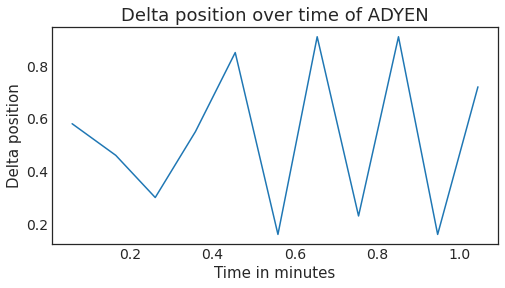

In [90]:
plot_dfPlot(df_plot_adyen, 'ADYEN')

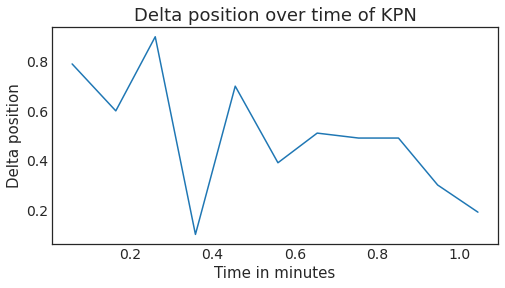

In [91]:
plot_dfPlot(df_plot_kpn, 'KPN')

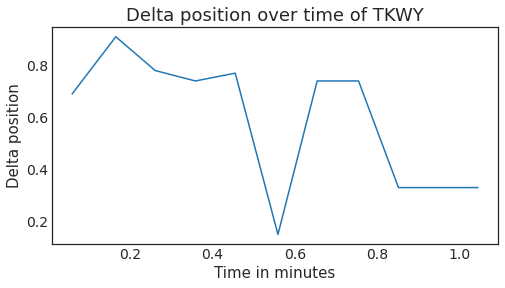

In [92]:
plot_dfPlot(df_plot_tkwy, 'TKWY')

In [93]:
def plotVega(df_plot, title):
    plt.plot(df_plot['Time'], df_plot['Vega'], label = 'Vega')
    plt.ylabel('Vega position')
    plt.title(f'Vega position over time of {title}')
    plt.xlabel('Time in minutes')
    # plt.legend()

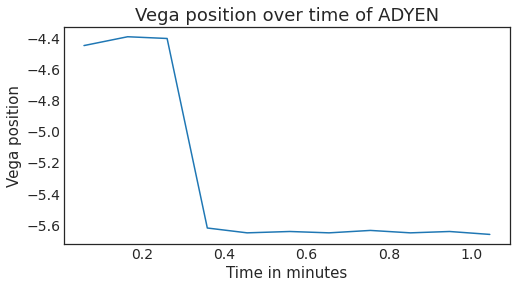

In [94]:
plotVega(df_plot_adyen, 'ADYEN')

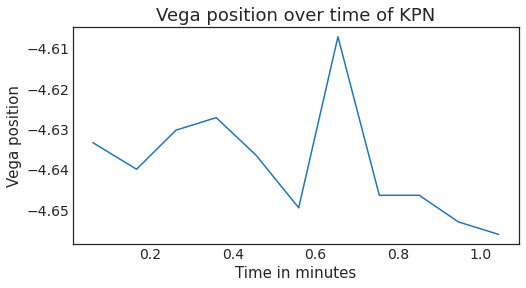

In [95]:
plotVega(df_plot_kpn, 'KPN')

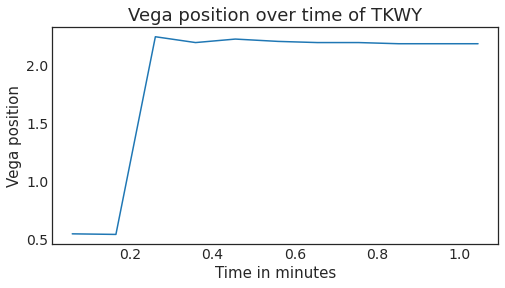

In [96]:
plotVega(df_plot_tkwy, 'TKWY')

In [97]:
def plot_PNL(df_plot, title):
    plt.plot(df_plot['Time'], df_plot['PNL from start'])
    plt.ylabel('PnL')
    plt.xlabel('Time in minutes')
    plt.title(f'PnL over time of {title}')

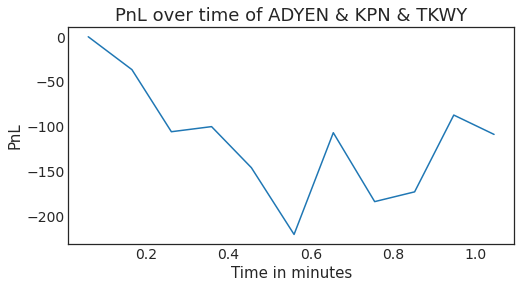

In [98]:
plot_PNL(df_plot_tkwy, 'ADYEN & KPN & TKWY')

In [79]:
def plotPositions(df_plot, title):
    plt.plot(df_plot['Time'], df_plot['Instrument position'])
    plt.ylabel(f'{title} position')
    plt.xlabel('Time in minutes')
    plt.title(f'{title} position over time')

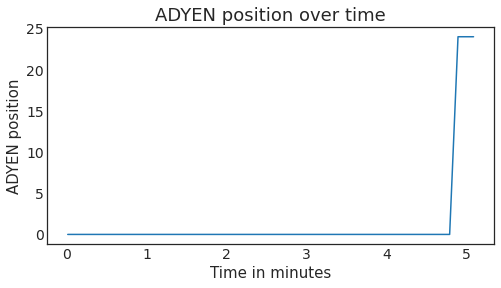

In [80]:
plotPositions(df_plot_tkwy, 'ADYEN')

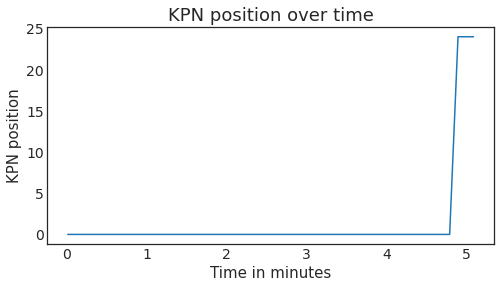

In [81]:
plotPositions(df_plot_tkwy, 'KPN')

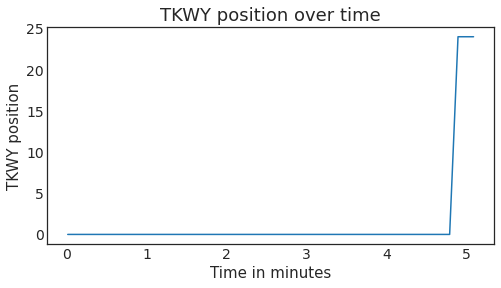

In [82]:
plotPositions(df_plot_tkwy, 'TKWY')

In [102]:
plt.rc('legend', fontsize=12) 

result = option_positions[0]

for i in range(1, len(option_positions)):
    result = pd.concat([result, option_positions[i]], axis=1)
    
result.columns = df_plot['Time']
result.index = df['id'].str.split('-', n = 2, expand=True)[2]

result[0:6].T.plot(alpha = 0.8)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)
plt.ylabel('Position size')
plt.xlabel('Time in minutes')
plt.title('Positions of Options expiring 29 April, 2022')

result[6:].T.plot(alpha = 0.8)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)
plt.ylabel('Position size')
plt.xlabel('Time in minutes')
plt.title('Positions of Options expiring 27 Mei, 2022')

NameError: name 'option_positions' is not defined